# Bayesian MaxEnt (BME) reweighting

This is a simple example showing the steps involved in the reweighting procedure.

## Data collection ##
We first need a set of experimental data and associated uncertainties. For this example, we have a set of 26 3J scalar couplings measured for an RNA tetranucleotide with sequence CCCC. The data is stored in the file `../data/couplings_exp.dat`

In [2]:
%cat ../data/couplings_exp.dat | head

# DATA=JCOUPLINGS PRIOR=GAUSS
0-H1H2 1.0 1.5
0-H2H3 3.6 1.5
0-H3H4 8.7 1.5
0-H3P 8.8 1.5
1-H1H2 1.0 1.5
1-H2H3 4.3 1.5
1-1H5H4 1.0 1.5
1-2H5H4 1.0 1.5
1-1H5P 3.8 1.5


The first line is an header, defining the type of data and the error model. In column 1 we have a user-defined label, that in this case specify the residue index and the pair of hydrogen atoms for which the scalar coupling was measured. Experimental average and uncertainty are in column 2 and 3, respectively. In this case the scalar coupling is measured in Hz, but the unit is not relevant as long as they are all consistent in the experimental and calculated data file. 
The corresponding calculated datafile `../data/couplings_calc.dat` has 27 columns (the first being a label, and then one column per experimental average). The number of rows depends on the simulation lenght and stride. In this case, we have 20000 frames.

In [7]:
%cat ../data/couplings_calc.dat | wc -l

   20000


Additionally, we have NOE distances. In this case, the experimental data looks like this:

In [46]:
%cat ../data/noe_exp.dat | head

# DATA=NOE PRIOR=GAUSS
C1_1H2'_C2_H1' 4.21 0.4
C1_1H2'_C2_1H5' 2.82 0.16
C1_H5_C2_H5 3.79 0.28
C1_H6_C1_H1' 3.46 0.22
C1_H6_C1_1H2' 3.38 0.22
C1_H6_C2_H5 3.66 0.25
C2_H5_C1_1H2' 4.43 0.49
C2_H5_C3_H5 3.80 0.28
C2_H6_C1_1H2' 2.73 0.15


To understand what is going on, we can plot the data, just to have an idea. We define here a plotting function that we will also use later. Note that the NOE averages are in  $\AA^-6$

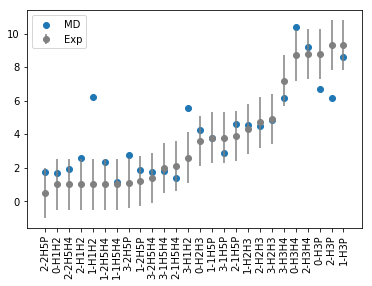

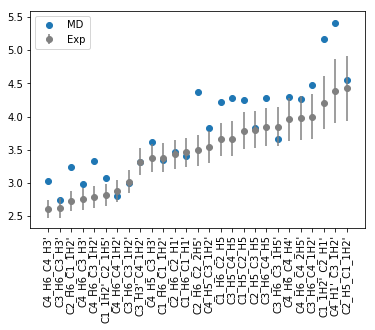

In [94]:
import matplotlib.pyplot as plt
import seaborn as sns

# define plotting function. 
def plot(f1,f2,wopt=[],w=None,power=None):
    exp_data = np.array([[float(x) for x in line.split()[1:]] for line in open(f1) if "#" not in line])
    labels = [line.split()[0] for line in open(f1) if "#" not in line]
    calc_data = np.array([[float(x) for x in line.split()[1:]] for line in open(f2) if "#" not in line])
    idxs = np.argsort(exp_data[:,0])
    xx = range(len(idxs))
    plt.errorbar(xx,exp_data[idxs,0],yerr=exp_data[idxs,1],fmt="o",label="Exp",c='gray')
    if(power!=None):
        avg = np.average(np.power(calc_data[:,idxs],-power),axis=0,weights=w)
        plt.scatter(xx,np.power(avg,-1./power),label = "MD")
    else:
        plt.scatter(xx,np.average(calc_data[:,idxs],axis=0,weights=w),label = "MD")
    if(len(wopt)!=0):
        if(power!=None):
            avg = np.average(np.power(calc_data[:,idxs],-power),axis=0,weights=wopt)
            plt.scatter(xx,np.power(avg,-1./power),label = "MD reweightes")
        else:
            plt.scatter(xx,np.average(calc_data[:,idxs],axis=0,weights=wopt),label = "MD, reweighted")
    plt.legend(loc=2)
    nl = [labels[i] for i in idxs]
    plt.xticks(xx,nl,rotation=90)
  

# define name of files                                                                               
exp_couplings = '../data/couplings_exp.dat'
calc_couplings = '../data/couplings_calc.dat'
exp_noe = '../data/noe_exp.dat'
calc_noe = '../data/noe_calc.dat'


# plot data
plot(exp_couplings,calc_couplings)
plt.show()

plot(exp_noe,calc_noe,power=6)
plt.show()

## $\Gamma$ minimization ##

Here, we show how to initialize the reweighting class, how to load the data and calculate $\chi^2$ before and after reweighting. We set $\theta=2$


In [16]:
# import modules
import sys
import os
cwd = os.getcwd()[:-8]
sys.path.append(cwd)
import bme_reweight as bme
import numpy as np

# initialize reweighting class                                                                                                                                
rew = bme.Reweight(verbose=False)
# load data                                                                                      
rew.load(exp_couplings,calc_couplings)
# do optimization using theta=2                                                                                                                               
chi2_before,chi2_after, srel = rew.optimize(theta=2)

print "# CHI2 before minimization: %8.4f" % (chi2_before)
print "# CHI2 after minimization:  %8.4f" % (chi2_after)
print "# Relative entropy:         %8.4f" % (srel)
print "# Effective frames:         %8.4f" % (np.exp(-srel))


# Warning: expt average 2-2H5P=0.5000     is smaller than minimum value in simulation 0.9920    
# exp data: (26, 2)
# calc data: (20000, 26)
Initial average chi square     1.1525, srel     0.0000 
# Minimization successful
Final average chi squared       0.1785, srel     0.9829 
# CHI2 before minimization:   1.1525
# CHI2 after minimization:    0.1785
# Relative entropy:           0.9829
# Effective frames:           0.3742


The chi2 drops from 1.15 to 0.18. Note also that a warning is issued whenever the experimental average
is not within the range spanned by the simulation. This might or might not be problematic, depending on the magnitude of the uncertainty sigma. 
Let's take a closer look at the data, to be sure that the averages calculated using the new weights are indeed better:

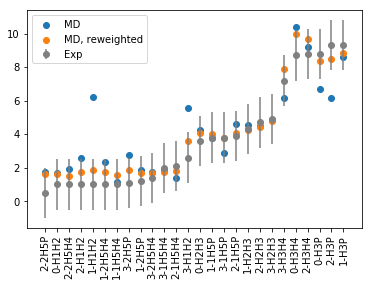

In [87]:
# returns the optimized weights
w_opt = rew.get_weights()

# feed the weights to plotting function
plot(exp_couplings,calc_couplings,wopt=w_opt)
plt.show()

## Cross-validation ## 

It is now important to cross validate the results of the reweighting. We can easily check this by using the new weights to calculate the NOE signal. Note that NOE were not used in the optimization. 
This can be done by calling the function `weight_exp()`

In [88]:
chi2_noe_before, chi2_noe_after = rew.weight_exp(exp_noe,calc_noe,"my_first_example")
print "# NOE CHI2 before minimization: %8.4f" % (chi2_noe_before)
print "# NOE CHI2 after minimization:  %8.4f" % (chi2_noe_after)

# NOE CHI2 before minimization:   1.1532
# NOE CHI2 after minimization:    0.9681


This function writes on the disk a file `my_first_example.stats.dat` that can be easily interpreted:

In [89]:
%cat my_first_example.stats.dat

# noe_exp.dat vs. noe_calc.dat srel=9.8289e-01
#  Label             avg exp sigma exp avg before avg after 
   C1_1H2'_C2_H1'  1.796e-04 1.024e-04 5.278e-05 1.314e-04  4.210e+00 4.000e-01 5.163e+00 4.435e+00 
   C1_1H2'_C2_1H5' 1.988e-03 6.769e-04 1.188e-03 3.259e-03  2.820e+00 1.600e-01 3.073e+00 2.597e+00 
   C1_H5_C2_H5     3.374e-04 1.496e-04 1.684e-04 4.467e-04  3.790e+00 2.800e-01 4.255e+00 3.617e+00 
   C1_H6_C1_H1'    5.828e-04 2.224e-04 6.414e-04 6.645e-04  3.460e+00 2.200e-01 3.405e+00 3.385e+00 
   C1_H6_C1_1H2'   6.707e-04 2.619e-04 7.123e-04 6.836e-04  3.380e+00 2.200e-01 3.346e+00 3.369e+00 
   C1_H6_C2_H5     4.160e-04 1.705e-04 1.757e-04 4.589e-04  3.660e+00 2.500e-01 4.225e+00 3.601e+00 
   C2_H5_C1_1H2'   1.323e-04 8.781e-05 1.131e-04 1.938e-04  4.430e+00 4.900e-01 4.547e+00 4.157e+00 
   C2_H5_C3_H5     3.321e-04 1.468e-04 3.164e-04 7.003e-04  3.800e+00 2.800e-01 3.831e+00 3.356e+00 
   C2_H6_C1_1H2'   2.416e-03 7.963e-04 8.687e-04 2.019e-03  2.730e+00 1.500e-01 3.23

For NOEs, the output is written both in distance as well as in 1/power units. Let's plot the NOEs with the old and new weights:

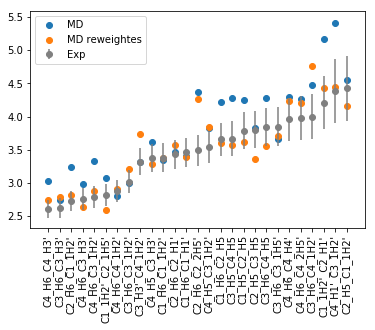

In [95]:
plot(exp_noe,calc_noe,wopt=w_opt,power=6)
plt.show()

## structural interpretation ##
We are now ready to look at what the weights means. This is very easy to do now that we have the weights. 


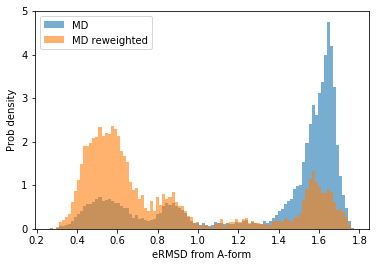

In [114]:
distances = np.array([[float(x) for x in line.split()[1:]] for line in open("../data/ermsd.opc.dat") if "#" not in line])
plt.hist(distances[:,0],bins=100,alpha=0.6,density=True,label="MD")
plt.hist(distances[:,0],bins=100,alpha=0.6,weights=w_opt,density=True,label="MD reweighted")
plt.legend()
plt.xlabel("eRMSD from A-form")
plt.ylabel("Prob density")
plt.show()
